#IOTA Toy Model Test of Invariants through NL Magnets


In an attempt to obtain a good working point for the IOTA lattice, which conserves the 1st and 2nd invariants, I have constructed a toy lattice. The lattice consists of the nonlinear magnets as described by the IOTA 6-6 madx files, followed by a simple R-matrix constructed from the remainder of the IOTA lattice. I have propagated a single particle through this lattice and present the calculated invariants. See below for an itemized summary.

###Summary

1. Construct R-matrix from the composition of elements in the `lattice_1IO.seq` sequence, which has been modified to begin at the end of the nonlinear element and end at the beginning of the nonlinear element. 
    - The modified sequence can be found in `lattices/Iota6-6/lattice_1IO_bare.madx`.
    - The R-matrix is constructed by first creating a lattice_simulator and then calling `lattice_simulator.get_linear_one_turn_map()`. The resulting lattice agrees with the code I wrote to grab each individiual linear map and multiply them together.
2. Create the `turn_end_action` object. The object takes the particle coordinates from the bunch, and multiplies them by the R-matrix. **For the original test, only the x and y 2x2 components are considered**. Dispersive (column 6) elements are ignored.
3. Load the IOTA nonlinear element into synergia as the simulation lattice. The file for this is `IOTA_nll.madx`. 
    - The lattice is first ammended to add the `chef_propagate` attribute to each nonlinear component, while individual drifts are kept linear. 
    - From this, the lattice_simulator and stepper are constructed. 10 steps per element are used.
4. Construct the bunch, stepper, diagnostics, and propagator. Run the simulation, outputing particle diagnostics at the end of each turn (thus at the beginning of the nonlinear drift, rather than at the middle.
5. In order to compute the invariants, the particle coordinates must be normalized. The `lattice_1IO.madx` file is used to compute the beta functions for the base lattice. 
    - Due to the s-coordinate discrepancy between this lattice and the `IOTA_nll` file used for propagation, an offset is computed to adjust how the beta functions are determined when running `singleparticle.normalized_coordinates()`. See my `singleparticle` script within the `base_diagnostics` module for details.
    - For this lattice, the offset is 4.911519143 m , the starting point of the first nonlinear magnet in the original lattice file.
6. The invariants are then computed, with the elliptic coordinate `c` being normalized by the beta function at the center of the drift ( $\beta = 0.6538$ ).

####Lattice Files Needed
    - `lattice_1IO_bare.madx` - The IOTA sequence starting with the end of the nonlinear element and ending at the beginning of the nonlinear element.
    - `IOTA_nll.madx` - A sequence consisting just of the NL element.
    - `lattice_1IO.madx` - The base IOTA lattice with no NL elements or sextupoles. This lattice is used for computing twiss functions through the NL drift, which are then used for normalization.


In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [3]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 13/08/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

##Construct the R-matrix from the remainder of the IOTA lattice

In [36]:
lattice = synergia.lattice.MadX_reader().get_lattice("iota","/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_bare.madx")

#10 steps per element
nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = 'iota_bare'
order = 1
outputdir = 'order_'+str(order)+'_'+name
opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)

#need to construct stepper prior to lattice simulator to generate appropriate number of slices
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#construct R-matrix from one-turn-map
bare_otm = lattice_simulator.get_linear_one_turn_map()
OTM = np.copy(bare_otm) #make a copy to pass to turn_end_action object
OTM_x = bare_OTM[0:2,0:2]
OTM_y = bare_OTM[2:4,2:4]

print 'Full R-Matrix:'
print
print OTM
print
print 'X component 2x2:'
print
print OTM_x
print
print 'Y component 2x2:'
print
print OTM_y
print
print 't-p component'
print
print OTM[4:6,4:6]

Full R-Matrix:

[[  1.00003870e+00  -4.03555423e-05   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.79732356e-06]
 [ -1.45446722e+00   1.00001999e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   5.65792130e-05]
 [  0.00000000e+00   0.00000000e+00   9.99949439e-01   6.06364824e-05
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.45447389e+00   9.99962365e-01
    0.00000000e+00   0.00000000e+00]
 [  5.91958922e-05  -1.79965313e-06   0.00000000e+00   0.00000000e+00
    1.00000000e+00   3.21622715e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00]]

X component 2x2:

[[  1.00003870e+00  -4.03555423e-05]
 [ -1.45446722e+00   1.00001999e+00]]

Y component 2x2:

[[  9.99949439e-01   6.06364824e-05]
 [ -1.45447389e+00   9.99962365e-01]]

t-p component

[[ 1.          3.21622715]
 [ 0.          1.        ]]


##Construct the `turn_end_action` operator

In [38]:
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, mat):
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self, mat)
        self.matrix = mat #R-matrix being imported
    def turn_end_action(self, stepper, bunch, turn_num):
        '''Move particles through a single drift and advance the reference particle by the drift length'''
        
        #define matrix
        R_matrix = self.matrix
        
        particles = bunch.get_local_particles();
        for particle in particles:
            #new_particle = np.dot(R_matrix,particle[0:6]) #This is for full 6x6 multiplication, not using currently.
            
            #just perform x+y-plane updates
            new_particle = np.zeros(6)
            new_particle[0:2] = np.dot(R_matrix[0:2,0:2],particle[0:2])
            new_particle[2:4] = np.dot(R_matrix[2:4,2:4],particle[2:4])
            particle[0:6] = new_particle
            
turn_action = turn_actions(OTM)

##Load the NLL element and construct the simulation stepper

In [40]:
lattice = synergia.lattice.MadX_reader().get_lattice("onlynll", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/IOTA_nll.madx")

for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = '1IO_nll_TURN_END'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)

##Construct the bunch, stepper, diagnostics, and propagator. Run the simulation

We are only simulating a single particle for now.

In [41]:
from elliptic import EllipticBeam6D
from elliptic import ellipticBeam
from scipy import constants as consts

gamma0 = 2.
speciesMass = consts.m_p
dgammaOgamma = 1.e-3
#We want dpop no dE/E
dpop = opts.dpop
#Assume Gaussian longitudinal profile - put bunch length in m
sigmaz = opts.stdz
#*consts.c
#bunchLength = sigmaz #sec
#transverseEmittance = 1.e-5 #m-rad
transverseEmittance = opts.emit_transverse
numMacroParticles = 1

#lattice = opts.lattice


#t = 0.45
#c = 0.0095
t = 0.4 #fixed for IOTA 6-6 for now
c = 0.01 #fixed for IOTA 6-6 for now
#beta = 0.7
#betaPrime = 0.

#calculate beta at injection - center of NL element
#beta = lf0.beta_x
#betaPrime = -2*lf0.alpha_x
beta = 0.6538
#betaPrime = 0.0002
betaPrime = 0.0

xOffset = 0. #m
yOffset = 0. #m

# Do not modify below this line
E0 = gamma0 * consts.m_p * consts.c**2 * 6.24150934e9 #GeV/J
ESpread = E0 * dgammaOgamma


#myBunchGenerator = ellipticBeam.ellipticBeam(t, c, beta, betaPrime)
#bunch = myBunchGenerator.generateBunch(transverseEmittance, numMacroParticles)
ref = lattice.get_reference_particle()
bucket_length = 1
real_particles = 1.e10
num_total_particles = 1
comm = synergia.utils.Commxx(True)
myBunch = synergia.bunch.Bunch(ref,num_total_particles, real_particles, comm, bucket_length)

particle = np.array([1.e-3,0.,1.e-3,0.,0.,0.,1.])
local_particle = myBunch.get_local_particles()
local_particle[:,:] = particle

myBunch.dpop = 0

In [42]:
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)

lattice_simulator = stepper.get_lattice_simulator()

# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

Now run the simulation

In [43]:
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, turn_action,
                     opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

##Use the base lattice for the purpose of normalizing coordinates for diagnostics

In [44]:
full_lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO.madx")

#nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
map_order = 1
full_stepper = synergia.simulation.Independent_stepper_elements(full_lattice, map_order, nsteps_per_element)
full_lattice_simulator = full_stepper.get_lattice_simulator()

I have already pre-calculated the offset, but I will update this code in the future to allow for variable offset configurations.

In [48]:
def find_offset(lattice):
    '''Find the position of the leading edge of the first nonlinear element '''
    for elem in full_lattice.get_elements():
        if elem.get_name() == 'nlr1':
            #print elem.get_double_attributes()
            offset = elem.get_double_attribute('at')
    return offset
offset = find_offset(full_lattice)
print offset

4.911519143


##Plot the invariants

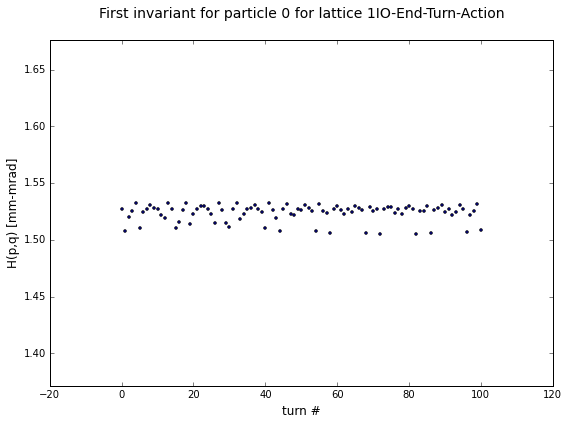

In [50]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.variance = 0.1
popts.save = True
singleparticle.plot_elliptic_Invariant(popts)
#singleparticle.plot_H_I(popts)

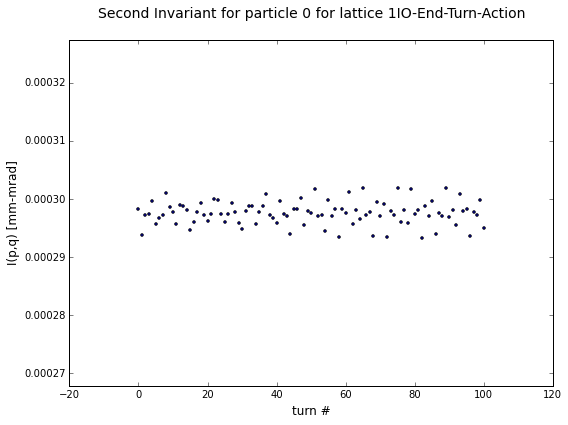

In [51]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 2
popts.variance = 0.1
popts.save = True
singleparticle.plot_elliptic_Invariant(popts)

Some quick number-crunching.

In [53]:
hArray = singleparticle.calc_elliptic_Invariant(popts)
singleparticle.stats_Invariant(hArray)

H -  Mean: 1.5236761063 [mm-mrad] std (%): 0.490529729014
H -  Mean: 0.000297630917509 [mm-mrad] std (%): 0.674060965109


####Plot some Poincare sections

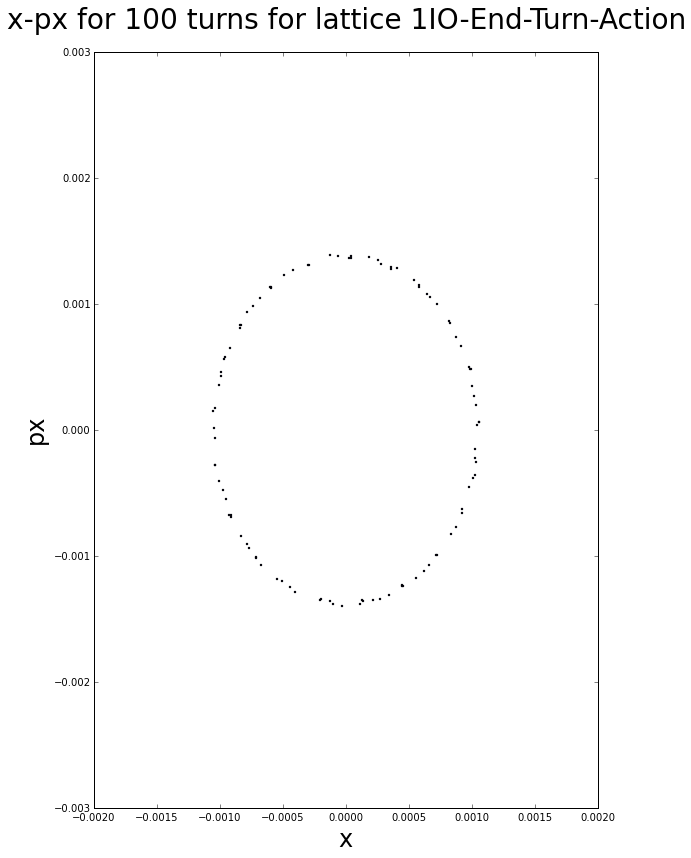

In [55]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-End-Turn-Action'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = full_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = full_lattice

popts.plots = ['x','px']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

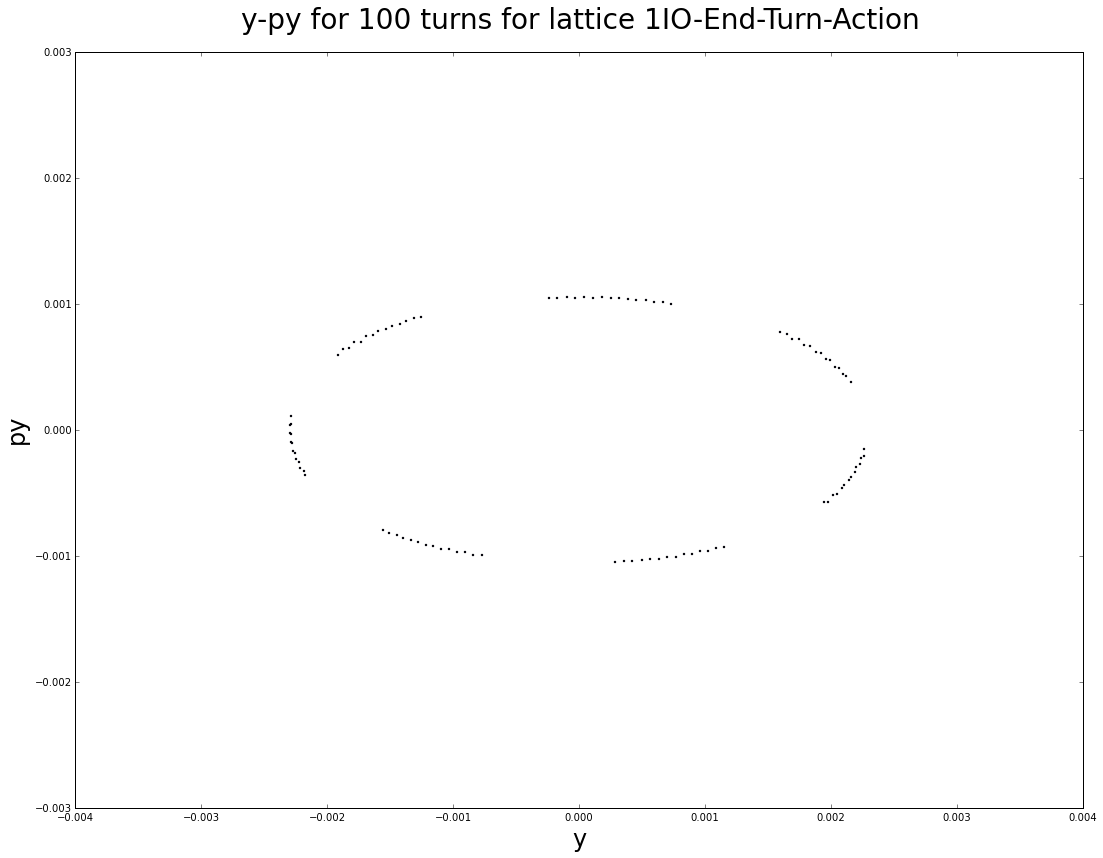

In [54]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-End-Turn-Action'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = full_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['y','py']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

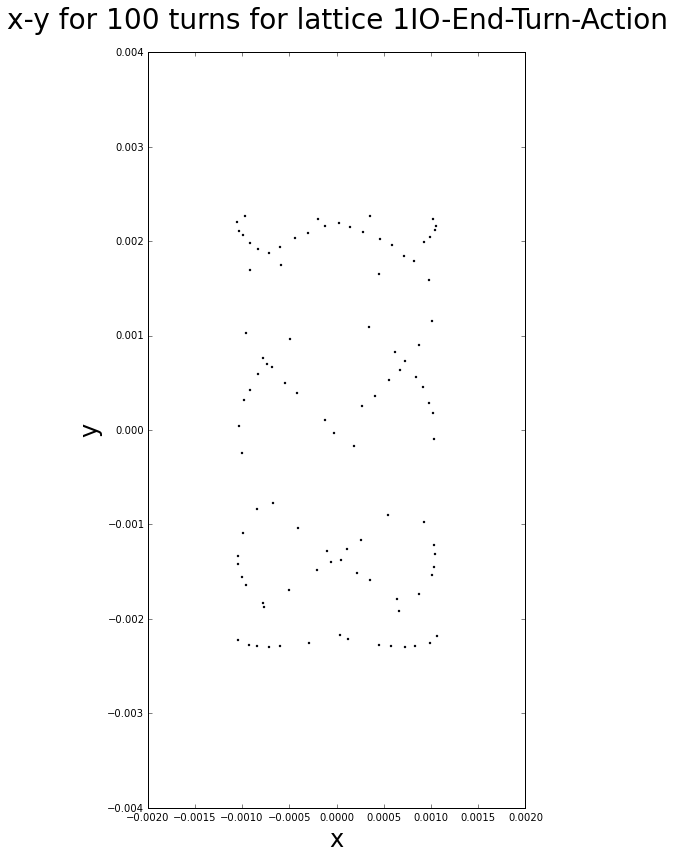

In [56]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-End-Turn-Action'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = full_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)